In [1]:
import os
from typing import List, DefaultDict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# from numpy.linalg import norm
# import matplotlib
from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment, get_model, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST, get_train_val_iterator
from clearn.dao.dao_factory import get_dao


import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator
from clearn.utils.data_loader import load_images
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z,get_significant_dimensions
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
from clearn.analysis.encode_decode import decode, encode, encode_and_get_features, decode_and_get_features, decode_l3
from clearn.analysis.cluster_utils import plot_features, trace_dim
from matplotlib import pyplot  as  plt

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [5]:
colormap = "Greys"

In [6]:
recompute_feature_vectors = False
z_dim = 10
run_id = 45
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

experiment_name = "semi_sup_gaussian_mah_k10"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=10,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

In [8]:
filename  = get_encoded_csv_file(exp_config, 5, "train")
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
df.shape

(59840, 63)

In [9]:
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(exp_config.Z_DIM)

In [10]:
def get_labels(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS):
    x,y = load_test_raw_data(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS)
    labels = np.unique(y)
    return labels
    

In [13]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
def get_mean(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.mean(axis=0)
    return mu_0


def get_min(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.min(axis=0)
    return mu_0


def get_max(i,df,mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.max(axis=0)
    return mu_0

In [15]:
mu_mean = []
mu_min = []
mu_max =[]
for i in labels:
    mu_mean.append( get_mean(i, df,z_col_names) )
    mu_min.append( get_min(i, df,z_col_names) )
    mu_max.append( get_max(i, df,z_col_names) )



In [16]:
print(mu_min[0])
print(mu_max[0])
print(mu_mean[0])

[-3.4535799  -3.31462288 -1.84145272 -3.65302277 -2.14644623 -1.50098062
 -2.57495522 -1.69926965 -2.83239174 -3.27748466]
[3.1652739  2.81780291 2.4107852  2.47560501 2.41669321 3.85226965
 2.44581032 3.75447774 3.13164258 1.70566988]
[-0.39242256 -0.39125951  0.32323063 -0.80205236  0.09606587  1.38192111
 -0.04162324  1.56219245  0.44855878 -0.78368257]


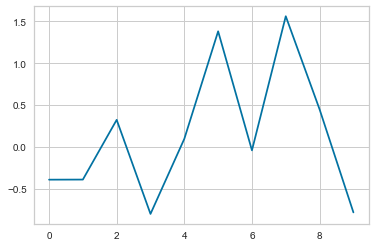

In [17]:
plt.plot(mu_mean[0])

In [24]:
def trace(exp_config, trace_from, trace_to, mu_mean, num_trace_steps, d):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, d ] = alpha_i * mu_mean[trace_to][d] + (1 - alpha_i) * mu_mean[trace_from][d]
    return z
    
    

In [25]:
def trace_dim(exp_config, mu, num_trace_steps,  dim):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
    for i in range(num_trace_steps):
        z[i] = mu
    z_min =  -5
    z_max = 5
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
    return z
    
    

In [30]:
d

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [26]:
d = list(range(len(labels)))
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

        
    total_latent_vectors = len(labels) + (len(labels) - 1) * num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    for i in range(len(mu_mean)):
        z[i, :] = mu_mean[i]
    num_latent_vectors = len(mu_mean)
        
    for label_index in range(len(labels) - 1):
        traced_from_to = trace(exp_config, label_index, label_index + 1, mu_mean, num_trace_steps, d)
        for i in range(num_trace_steps):
            z[ num_latent_vectors, :] = traced_from_to[i]
            num_latent_vectors += 1
    reconstructed_images = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

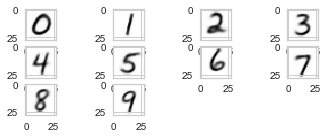

In [27]:
figure = plt.subplot(3, 3, 1)
for i in range(len(labels) ):
    plt.subplot(6, 4, i+1)
    plt.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    


# Trace from one label to next

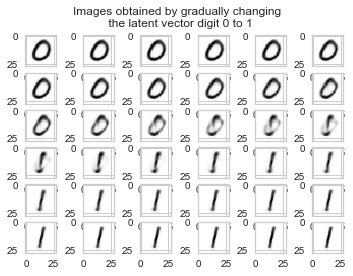

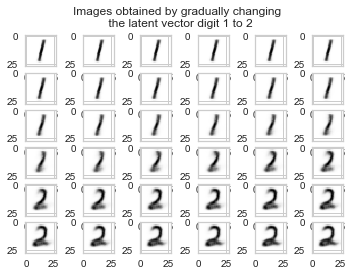

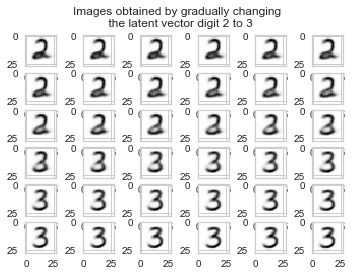

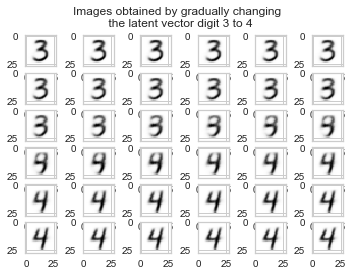

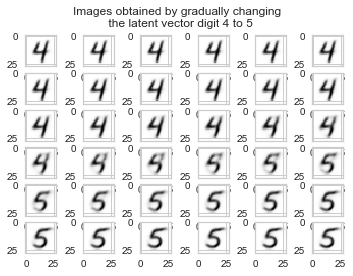

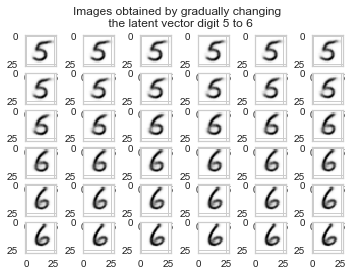

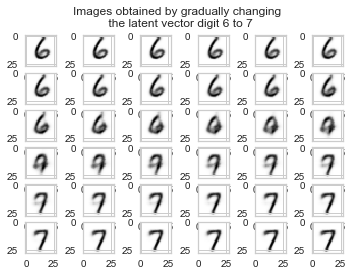

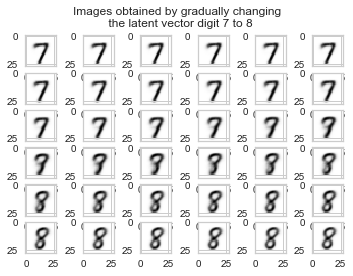

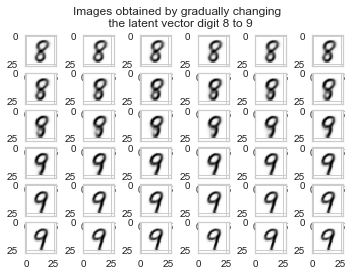

In [29]:
num_images_plotted = len(labels)
title_string = "Images obtained by gradually changing \n the latent vector digit {} to {}"
for j in range(len(labels) - 1):
    fig = plt.figure()
    fig.suptitle(title_string.format(j,j+1))
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6,6,i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_path_{}.png".format(j))

In [16]:
num_trace_steps = 36
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=Z_DIM,
            dataset_name=DATASET_NAME)
    model.set_result_directories(log_dir=LOG_PATH,
            checkpoint_dir=TRAINED_MODELS_PATH,
            result_dir=PREDICTION_RESULTS_PATH)

    # build graph
    model.build_model()

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    num_latent_vectors = 0
    total_latent_vectors = len(labels) * Z_DIM * num_trace_steps
    if total_latent_vectors < BATCH_SIZE:
        total_latent_vectors = BATCH_SIZE
    z = np.zeros([total_latent_vectors, Z_DIM])
    for d in range(10):
        for dimension in range(Z_DIM):
            traced_from_to = trace_dim(exp_config, mu_mean[d], num_trace_steps, dimension)
            for i in range(num_trace_steps):
                z[ num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
    reconstructed_images = decode(model, z, BATCH_SIZE)
    
    z = np.zeros([BATCH_SIZE,Z_DIM])
    for i in range(10):
        z[i,:] = mu_mean[i]
    reconstructed_images_mean = decode(model,z,BATCH_SIZE)

W0611 08:26:57.342335 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:62: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0611 08:26:57.349895 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:72: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0611 08:26:57.351211 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/tensorflow_wrappers/layers.py:35: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0611 08:26:57.479568 140736102474624 deprecation_wrapper.py:119] From /Users/sunilkumar/gitprojects/concept_learning/generative_models/vae.py:126: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0611 08:26:57.578041 140736102474624 deprecation_wrapper.py:119

 [*] Reading checkpoints...
 [*] Success to read VAE.model-4676
 [*] Load SUCCESS
Check point counter 4676
reconstructed_images (3600, 28, 28, 1)
reconstructed_images (64, 28, 28, 1)


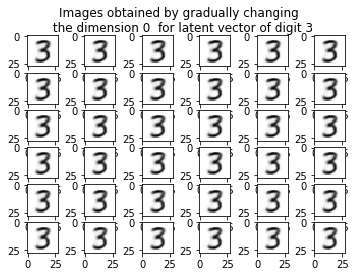

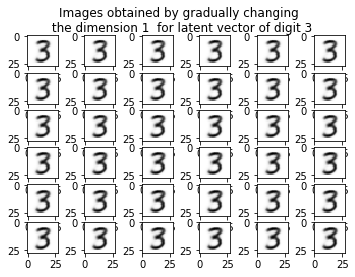

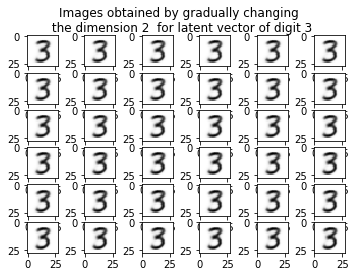

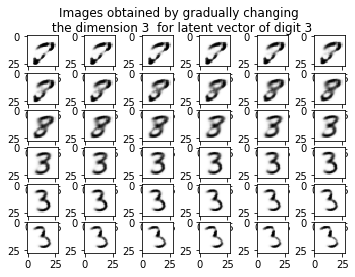

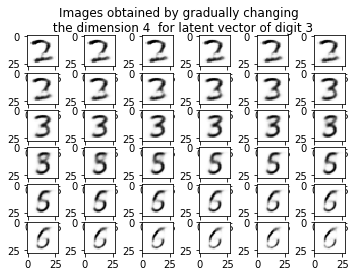

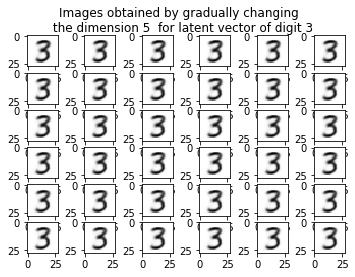

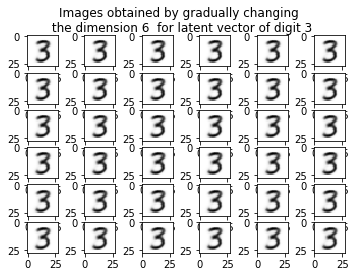

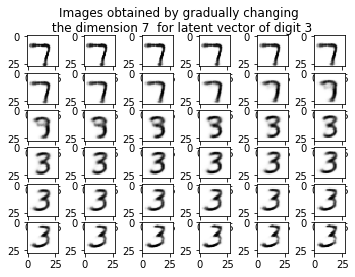

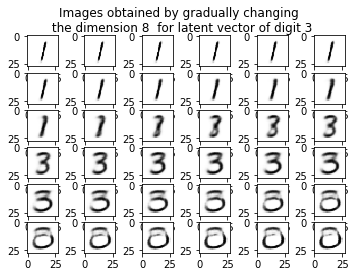

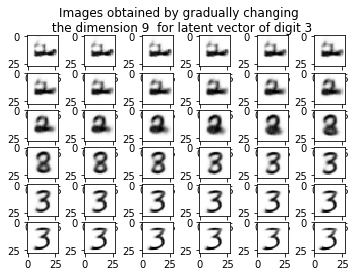

In [17]:
d = 3

num_images_plotted = d * Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    fig.suptitle(title_string.format(dim,d))
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6,6,i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    num_images_plotted += num_trace_steps
    plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

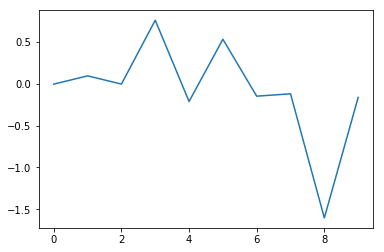

In [19]:
plt.plot(mu_mean[0])

In [20]:
z.shape
d

3

In [21]:
from collections import defaultdict
sensitive_dimensions = defaultdict(list)
for d in range(10):
    num_digits_completed = d * num_trace_steps * Z_DIM
    for dim in range(Z_DIM):
        distances = []
        for step_num in range(num_trace_steps):
            distances.append(np.linalg.norm(reconstructed_images_mean[d] - reconstructed_images[num_digits_completed + num_trace_steps * dim : num_digits_completed + (num_trace_steps * dim) + step_num] ))
        max_distance = max(distances)
        #print("Dimension {} Senssitivity {}".format(dim,max_distance))

        if max_distance > 10:
            sensitive_dimensions[d].append(dim)
        

In [22]:
for k,i in sensitive_dimensions.items():
    print(k,i)

0 [3, 4, 7, 8, 9]
1 [3, 4, 7, 8, 9]
2 [3, 4, 7, 8, 9]
3 [3, 4, 7, 8, 9]
4 [3, 4, 7, 8, 9]
5 [3, 4, 7, 8, 9]
6 [3, 4, 7, 8, 9]
7 [3, 4, 7, 8, 9]
8 [3, 4, 7, 8, 9]
9 [3, 4, 7, 8, 9]


In [30]:
for d in range(10):
    indices = np.asarray(sensitive_dimensions[d])
    print(d,np.asarray(mu_mean)[d,indices])

0 [ 0.76076254 -0.21150259 -0.11960177 -1.60469779 -0.16310475]
1 [-0.85187098  0.27899958 -0.39024506  1.68736951  0.61215616]
2 [-0.31093972  1.44523772 -0.71988543 -0.21614072  0.41886294]
3 [-0.32124347  0.77561136 -0.13493117 -0.22187004 -1.64137167]
4 [ 0.19078674 -0.66286678  0.76484983  0.37643463  0.87537385]
5 [ 0.75850697 -0.71040357 -0.69022703 -0.21793607 -0.22807238]
6 [-0.84798371 -0.99053859 -0.60009154 -0.3213101   0.90227732]
7 [ 0.69633625  0.39777007  1.61531765  0.35115794 -0.31290799]
8 [ 0.42246924  0.27279729 -0.01882608 -0.06589761 -0.5518225 ]
9 [ 0.2480715  -0.53572867  0.99661625  0.31042191 -0.02643614]


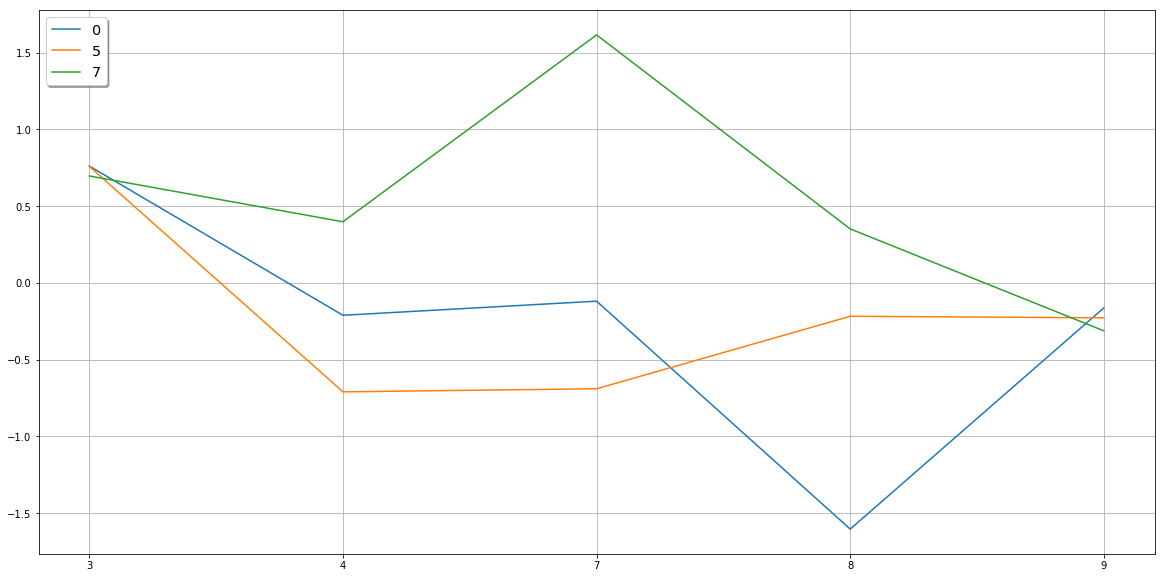

In [43]:

xticks = np.arange(0, indices.shape[0], 1)
plt.figure(figsize=(20,10))
plt.grid(which="both", axis="both")
for d in [0,5,7]:
    plt.plot(np.asarray(mu_mean)[d,indices],label =str(d))
    plt.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.xticks(xticks,indices)
